In [1]:
import jax
import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions

from jaxns.framework.model import Model
from jaxns.framework.prior import Prior


def prior_model():
    mu = yield Prior(tfpd.Normal(loc=0., scale=1.))
    # Let's make sigma a parameterised variable. 
    # It requires a name, but will not be collected as a Bayesian variable.
    sigma = yield Prior(tfpd.Exponential(rate=1.), name='sigma').parametrised()
    x = yield Prior(tfpd.Cauchy(loc=mu, scale=sigma), name='x')
    uncert = yield Prior(tfpd.Exponential(rate=1.), name='uncert')
    return x, uncert


def log_likelihood(x, uncert):
    return tfpd.Normal(loc=0., scale=uncert).log_prob(x)


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

# You can sanity check the model (always a good idea when exploring)
model.sanity_check(key=jax.random.PRNGKey(0), S=100)

INFO[2024-02-28 09:00:02,722]: Unable to initialize backend 'cuda': 
INFO[2024-02-28 09:00:02,723]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-02-28 09:00:02,724]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2024-02-28 09:00:02,724]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
INFO[2024-02-28 09:00:04,191]: Sanity check...
INFO[2024-02-28 09:00:04,885]: Sanity check passed


In [2]:
# Sample the prior in U-space (base measure)
U = model.sample_U(key=jax.random.PRNGKey(0))
# Transform to X-space
X = model.transform(U=U)
# Only named Bayesian prior variables are returned, the rest are treated as hidden variables.
assert set(X.keys()) == {'x', 'uncert'}

# Get the return value of the prior model, i.e. the input to the likelihood
x_sample, uncert_sample = model.prepare_input(U=U)

In [3]:
# Evaluate different parts of the model
log_prob_prior = model.log_prob_prior(U)
log_prob_likelihood = model.log_prob_likelihood(U, allow_nan=False)
log_prob_joint = model.log_prob_joint(U, allow_nan=False)

In [4]:
init_params = model.params


def log_prob_joint_fn(params, U):
    # Calling model with params returns a new model with the params set
    return model(params).log_prob_joint(U, allow_nan=False)


value, grad = jax.value_and_grad(log_prob_joint_fn)(init_params, U)
print(value, grad)

-8.101052 {'~': {'sigma_param': Array(-11.244353, dtype=float32)}}


In [5]:
from jaxns import DefaultNestedSampler

ns = DefaultNestedSampler(model=model, max_samples=1e5)

# Run the sampler
termination_reason, state = ns(jax.random.PRNGKey(42))
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 77219
samples: 1440
phantom samples: 0
likelihood evals / sample: 53.6
phantom fraction (%): 0.0%
--------
logZ=-1.5 +- 0.11
H=-1.09
ESS=233
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.79 +- 0.74 | 0.07 / 0.56 / 1.88 | 0.0 | 0.0
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x: -0.04 +- 0.65 | -0.91 / -0.01 / 0.8 | -0.0 | -0.0
--------


/home/albert/git/jaxns/jaxns/plotting.py:47: RuntimeWarning: divide by zero encountered in divide
  efficiency = 1. / num_likelihood_evaluations_per_sample


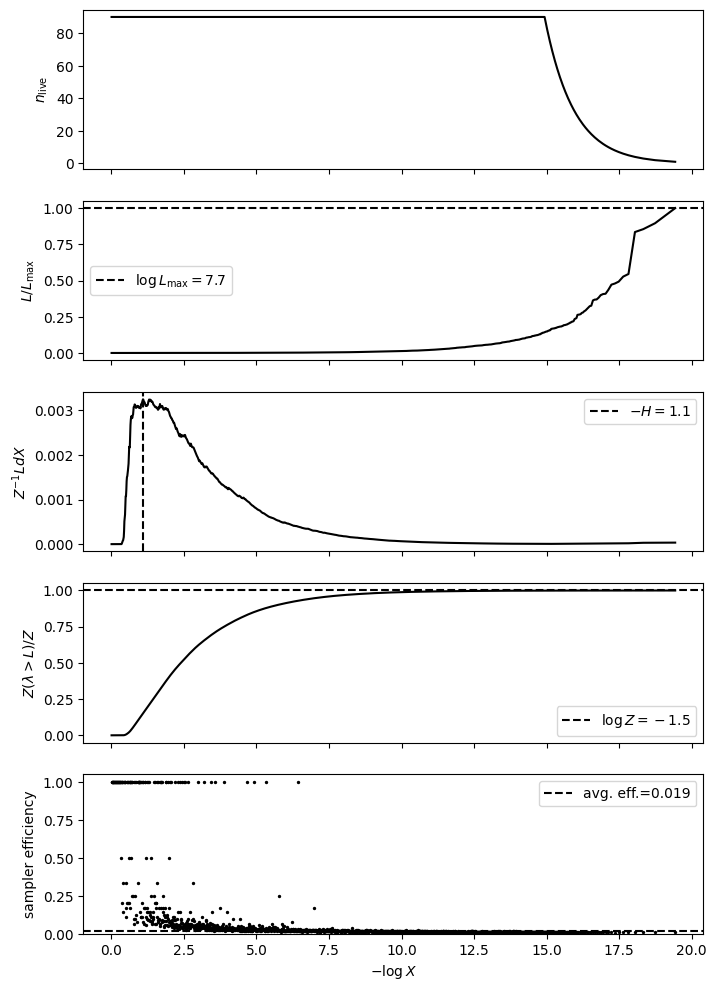

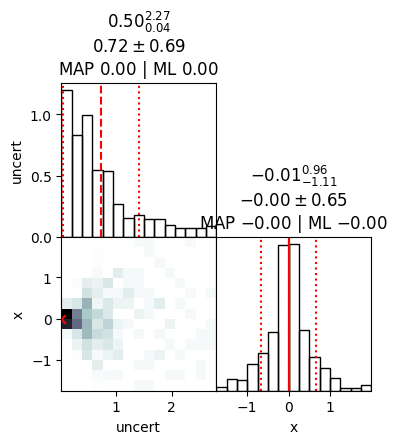

In [6]:
from jaxns import summary, plot_diagnostics, plot_cornerplot

summary(results)
plot_diagnostics(results, save_name='intro_diagnostics.png')
plot_cornerplot(results, save_name='intro_cornerplot.png')

In [7]:
from jaxns import resample

samples = resample(
    key=jax.random.PRNGKey(0),
    samples=results.samples,
    log_weights=results.log_dp_mean,
    S=1000,
    replace=True
)

Convergence achieved at step 3.:  60%|██████    | 3/5 [00:15<00:10,  5.05s/it]                                                                                                                                                          


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 72466
samples: 1440
phantom samples: 0
likelihood evals / sample: 50.3
phantom fraction (%): 0.0%
--------
logZ=-1.119 +- 0.098
H=-0.93
ESS=241
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 5.40077599e-05 +- 3.6e-12 | 5.40077563e-05 / 5.40077563e-05 / 5.40077563e-05 | 5.40077563e-05 | 5.40077563e-05
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.6 +- 0.54 | 0.05 / 0.45 / 1.37 | 0.0 | 0.0
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x: 0.01 +- 0.56 | -0.6 / -0.0 / 0.69 | 0.0 | -0.0
--------


/home/albert/git/jaxns/jaxns/plotting.py:188: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(per_1, per_99)
/home/albert/git/jaxns/jaxns/plotting.py:236: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(param_limits[parameters[col]])


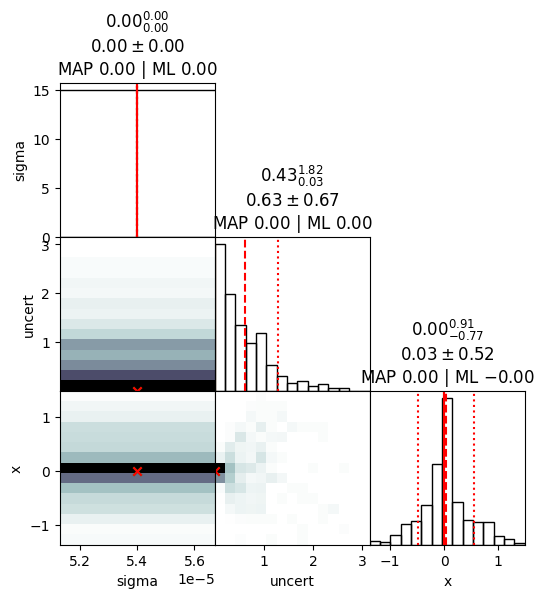

In [8]:
from jaxns.experimental import EvidenceMaximisation

# Let's train the sigma parameter to maximise the evidence

em = EvidenceMaximisation(model, ns_kwargs=dict(max_samples=1e4))
results, params = em.train(num_steps=5)

summary(results, with_parametrised=True)
plot_cornerplot(results, with_parametrised=True)